<a href="https://colab.research.google.com/github/ebatty/ComputationalBootcamp/blob/master/content/BootstrapandPermutation_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bootstrapping & Permutation Tests

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# @markdown Plotting Functions

def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim());

# Section 1: Bootstrapping

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a widely applicable method to assess confidence/uncertainty about estimated descriptive 
statistics or parameters, it was originally [proposed](https://projecteuclid.org/euclid.aos/1176344552) by [Bradley Efron](https://en.wikipedia.org/wiki/Bradley_Efron). 

The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding the statistics/estimators for each one of these new datasets, and finally looking at the distribution of all these statistics/estimators to quantify our confidence.

Let's say we have data from randomly sampled neurons. For each neuron, we have the average firing rate of the neuron and the size of the neuron. Please note this is completely faked data for illustration purposes so units etc don't make sense.



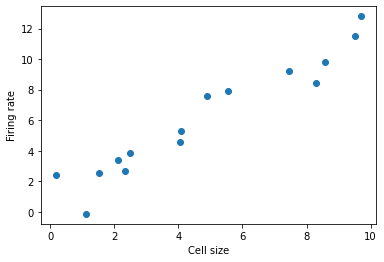

In [ ]:
#@markdown Execute this cell to simulate some data

# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 15

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='Cell size', ylabel='Firing rate');

cell_sizes = x
firing_rates = y

You have a `cell_sizes` variable and a `firing_rates` variable. Each is an array of length N, where N is the number of data points (cells) we have info about.

## Section 1.1: Bootstrapping to determine confidence in mean firing rate



### Exercise 1: Compute mean cell size

In [ ]:
np.mean(cell_sizes)

4.791300958941231

How confident are you that that is the mean cell size of this whole population of neurons?

We can quantify uncertainty using bootstrapping!



### Exercise 2: Resample data with replacement

First, we need a method to resample from our cell size dataset with replacement. Complete the code below to  resample a dataset with replacement. 


**Hint:** The [numpy.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) method would be useful here.

In [ ]:
# Resample dataset

# Get array of indices for resampled points
sample_idx = np.random.choice(cell_sizes.shape[0], size = cell_sizes.shape[0], replace=True)

# Sample from cell_sizes according to sample_idx
cell_size_ = cell_sizes[sample_idx]

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

### Exercise 3: Bootstrap estimates

We want to resample from our cell sizes dataset 2000 times, compute the mean each time, and store each mean in a variable called `bootstrapped_means`. 

With your group, write out pseudocode for how to do this, then implement it. You should use what you came up with in Exercise 2.

(array([ 29., 109., 344., 483., 501., 338., 151.,  41.,   3.,   1.]),
 array([2.4679177 , 3.03186822, 3.59581874, 4.15976925, 4.72371977,
        5.28767029, 5.85162081, 6.41557132, 6.97952184, 7.54347236,
        8.10742287]),
 <a list of 10 Patch objects>)

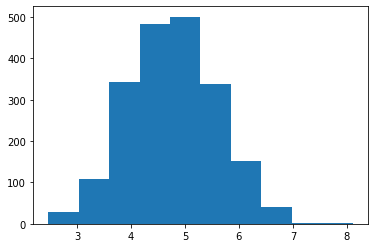

In [ ]:
# your code here
n_bootstraps = 2000
bootstrapped_means = np.zeros(n_bootstraps,)
for i in range(n_bootstraps):
  sample_idx = np.random.choice(cell_sizes.shape[0], size = cell_sizes.shape[0], replace=True)

  # Sample from cell_sizes according to sample_idx
  cell_size_ = cell_sizes[sample_idx]

  bootstrapped_means[i] = cell_size_.mean()

plt.hist(bootstrapped_means)

The histogram of the bootstrapped means gives you a sense of the uncertainty in the cell size mean you computed from the original dataset. Let's quantify that uncertainty. We do so by computing [confidence intervals](https://en.wikipedia.org/wiki/Confidence_interval) (CIs) from our bootstrapped estimates. The confidence interval is the probability that the mean will fall between a set of values for a certain proportion of time.

The most direct approach to compute confidence intervals is to compute percentiles from the empirical distribution of bootstrapped estimates. Note that this is widely applicable as we are not assuming that this empirical distribution is Gaussian.

If we aim to compute the 95% confidence interval, we want to figure out what value is the 2.5 percentile and what value is the 97.5 percentile. These two values are the edges of our 95% confidence interval.



### Exercise 4: Compute 95% confidence interval

Compute the 95% confidence interval. `np.percentile` should help - take a look at the documentation to know how to use it. 

In [ ]:
print(np.percentile(bootstrapped_means, 2.5))
print(np.percentile(bootstrapped_means, 97.5))

3.1891286469552207
6.365614897090727


## Section 1.2: Bootstrapping to determine confidence in linear regression parameter

**This section is more advanced, please come back to it after finishing the rest of the tutorial.** This section is based on and uses material from NMA Comp Neuro W1D2 (https://compneuro.neuromatch.io/tutorials/W1D2_ModelFitting/student/W1D2_Tutorial3.html)


Let's say we want to fit a linear regression model to predict firing rate based on cell size. We then want to get a sense of the uncertainty of our fitted parameter.

Implement a method to resample a dataset with replacement, similar to exercise 2 but for both cell size and firing rate data. The method accepts 𝐱 and 𝐲 arrays. It should return a new set of 𝐱′ and 𝐲′ arrays that are created by randomly sampling from the originals.

We will then compare the original dataset to a resampled dataset.

Hint: The numpy.random.choice method would be useful here.

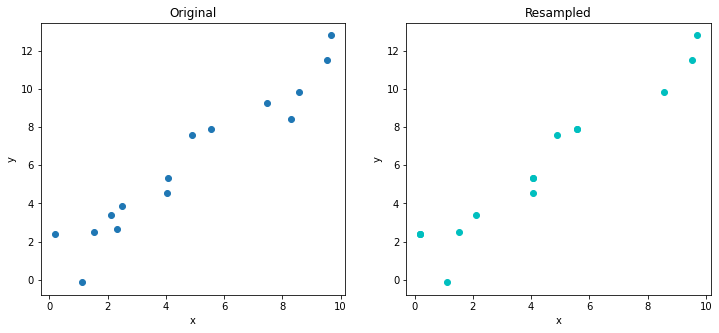

In [ ]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.

  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """
  #######################################################
  ## TODO for students: resample dataset with replacement
  # Fill out function and remove
  # raise NotImplementedError("Student exercise: resample dataset with replacement")
  #######################################################

  # Get array of indices for resampled points
  sample_idx = np.random.choice(len(x), size=len(x), replace=True)

  # Sample from x and y according to sample_idx
  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

cell_sizes_, firing_rates_ = resample_with_replacement(cell_sizes, firing_rates)

plot_original_and_resample(cell_sizes, firing_rates, cell_sizes_, firing_rates_)

In this exercise you will implement a method to run the bootstrap process of generating a set of 𝜃̂  values from a dataset of inputs (𝐱) and measurements (𝐲). You should use resample_with_replacement here, and you may also invoke the helper function solve_normal_eqn to produce the MSE-based estimator.

We will then use this function to look at the theta_hat from different samples.

Execute this cell for helper function solve_normal_eqn



In [ ]:
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.

    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    thata_hat (float): An estimate of the slope parameter.

  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """
  theta_hat = (x.T @ y) / (x.T @ x)
  return theta_hat


In [ ]:
def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute
  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute theta_hat for this sample
    theta_hats[i] = solve_normal_eqn(x_, y_)

  return theta_hats

# Set random seed
np.random.seed(123)

# Get bootstrap estimates
theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])

[1.27550888 1.17317819 1.18198819 1.25329255 1.20714664]


Now that we have our bootstrap estimates, we can visualize all the potential models (models computed with different resampling) together to see how distributed they are.



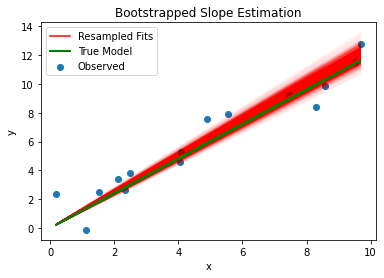

In [ ]:
#@markdown Execute this cell to visualize all potential models

fig, ax = plt.subplots()

# For each theta_hat, plot model
theta_hats = bootstrap_estimates(x, y, n=2000)
for i, theta_hat in enumerate(theta_hats):
  y_hat = theta_hat * x
  ax.plot(x, y_hat, c='r', alpha=0.01, label='Resampled Fits' if i==0 else '')

# Plot observed data
ax.scatter(x, y, label='Observed')

# Plot true fit data
y_true = theta * x
ax.plot(x, y_true, 'g', linewidth=2, label='True Model')

ax.set(
  title='Bootstrapped Slope Estimation',
  xlabel='x',
  ylabel='y'
)

# Change legend line alpha property
handles, labels = ax.get_legend_handles_labels()
handles[0].set_alpha(1)

ax.legend();

This looks pretty good! The bootstrapped estimates spread around the true model, as we would have hoped. Note that here we have the luxury to know the ground truth value for 𝜃, but in applications we are trying to guess it from data. Therefore, assessing the quality of estimates based on finite data is a task of fundamental importance in data analysis

mean = 1.24, std = 0.05


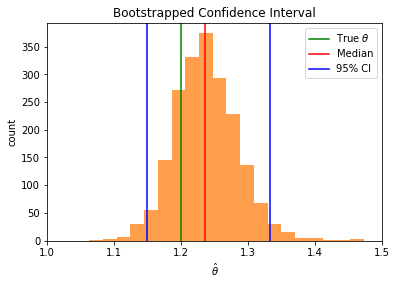

In [ ]:
#@markdown Execute this cell to plot bootstrapped CI

theta_hats = bootstrap_estimates(x, y, n=2000)
print(f"mean = {np.mean(theta_hats):.2f}, std = {np.std(theta_hats):.2f}")

fig, ax = plt.subplots()
ax.hist(theta_hats, bins=20, facecolor='C1', alpha=0.75)
ax.axvline(theta, c='g', label=r'True $\theta$')
ax.axvline(np.percentile(theta_hats, 50), color='r', label='Median')
ax.axvline(np.percentile(theta_hats, 2.5), color='b', label='95% CI')
ax.axvline(np.percentile(theta_hats, 97.5), color='b')
ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{{\theta}}$',
    ylabel='count',
    xlim=[1.0, 1.5]
);

Looking at the distribution of bootstrapped 𝜃̂  values, we see that the true 𝜃 falls well within the 95% confidence interval, which is reassuring. 



# Section 2: Permutation test

This is exercise is based on one created by Rick Born for the Quantitative Methods Bootcamp at Harvard.


Our data consists of measurements of the sizes of cell bodies of two populations of neurons, which we'll refer to as "feedback" (FB) neurons or "feedforward" (FF) neurons. 

We want to determine if the cell bodies of FB cells are significantly bigger than those of FF cells. 

We will use a permutation test to determine this.

In [ ]:
my_data = np.genfromtxt('./cell_body_area.csv', delimiter=',')
print(my_data.shape)

# Cell sizes for FB cells are in the first column;
# FF cells are in the 2nd column:
fb_cells = my_data[:,0]
ff_cells = my_data[:,1]


(50, 2)


## Exercise 5: How many cells do we have?

In [ ]:
# Calculate the # of cells
n_fb_cells = fb_cells.shape[0]
n_ff_cells = ff_cells.shape[0]
n_total = n_fb_cells + n_ff_cells
print(n_total)

100


## Exercise 6: Difference in cell body size

Compute the experimentally obtained value for the difference in mean cell body size. Note the sign of the difference matters because we are specifically testing if FB cells are larger than FF cells.

In [ ]:
real_size_diff = np.mean(fb_cells) - np.mean(ff_cells)
print(real_size_diff)

28.46409325959999


## Exercise 7: Implement permutation test

We want to look at 10000 permutations of the data . For each permutaiton, we want to shuffle which cell type each data point belongs to, split the data into fake FB and FF populations,  and computing the difference. Store the difference in `all_mean_diffs`, which should be a 10000 length array.

Work with your group to write pseudocode and then implement this permutation test.

In [ ]:
n_permutations = 10000
# place to store the results
all_mean_diffs = np.zeros(n_permutations,)

# First key step: pool all the data
pooled_data = np.concatenate((fb_cells, ff_cells), axis = 0);
# print(pooled_data.shape)

for k in range(n_permutations):
    shuffled_data = pooled_data[np.random.permutation(n_total),]
    fb_cell_star = shuffled_data[0:n_fb_cells,]
    ff_cell_star = shuffled_data[n_fb_cells:,]

    all_mean_diffs[k] = np.mean(fb_cell_star) - np.mean(ff_cell_star)


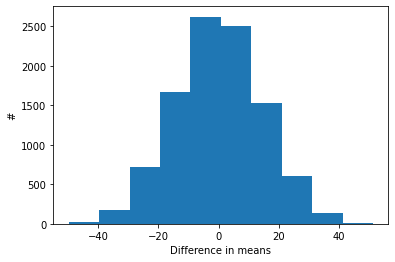

In [ ]:
# plot histogram
fig, ax = plt.subplots()
ax.hist(all_mean_diffs);
ax.set(xlabel = 'Difference in means', 
       ylabel = '#');


## Exercise 8: Compute p-value

The p-value is the proportion of samples that have a `test statistic` larger than that of our observed data. In this situation, the test statistic is the mean difference between FB and FF cell bodies.

Compute this p-value

In [ ]:
p_perm_onesided = np.sum(all_mean_diffs >= real_size_diff) / n_permutations
print(p_perm_onesided)

0.0237


Would you conclude that FB cells have significantly bigger cell bodies than FF cells?4

Yes, the p-value (probability of the null distribution) is quite low

## Exercise 9: 2-tailed test

Now suppose we wanted a 2-tailed version of this test. That is, we're interested in any difference more extreme than the one we got, regardless of whether FB are larger than FF or vice versa. Compute the p value assuming this new 2-tailed test (hint: you do not have to redo the permutation simulation part) 

In [ ]:
p_perm_twosided = np.sum(np.abs(all_mean_diffs) >= np.abs(real_size_diff)) / n_permutations
print(p_perm_twosided)

0.0484
